# MATH 514 Final Project: Numerical Pricing of American/European Options via Method of Lines

**Course:** MATH 514 - Numerical Analysis  
**Student Name:** Yifan Yang  
**Date:** December 2025

## 0. Introduction
The goal of this project is to solve the Black-Scholes Partial Differential Equation (PDE) numerically to price European Call Options. Instead of using Finite Difference Methods (FDM) on both space and time simultaneously, we employ the **Method of Lines (MOL)**. 

We first discretize the spatial domain (asset price $S$) to convert the PDE into a large system of Ordinary Differential Equations (ODEs). We then solve this stiff ODE system using two time-stepping methods from Chapter 12 of Süli & Mayers:
1.  **Backward Euler**: A first-order, A-stable implicit method.
2.  **BDF2**: A second-order, A-stable implicit multistep method (with Backward Euler start-up).

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os

# solver
from BS_Solver import BSParams, exact_solution, solve_ode_system

# auto-saved images folder
if not os.path.exists('images'):
    os.makedirs('images')
    print("Directory 'images' created.")
else:
    print("Directory 'images' already exists.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Directory 'images' already exists.


## 1.Mathematical Formulation: Method of Lines

### 1.1 The Black-Scholes PDE with Dividends
Let $V(S, \tau)$ be the value of the option, where $S$ is the asset price and $\tau = T - t$ is the time to expiry. We consider a continuous dividend yield $q$. The governing equation is:

$$
\frac{\partial V}{\partial \tau} = \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + (r - q) S \frac{\partial V}{\partial S} - rV
$$

Subject to boundary and initial conditions for a Call Option ($K$ is strike price):
* **Initial Condition** (Payoff at $\tau=0$): $V(S, 0) = \max(S - K, 0)$
* **Left Boundary** ($S \to 0$): $V(0, \tau) = 0$
* **Right Boundary** ($S \to S_{\max}$): $V(S_{\max}, \tau) \approx S_{\max} e^{-q\tau} - K e^{-r\tau}$

### 1.2 Semi-Discretization (Method of Lines)
We discretize the domain $[0, S_{\max}]$ into $M$ intervals of size $\Delta S$. Let $V_i(\tau) \approx V(i\Delta S, \tau)$. Using central differences for spatial derivatives:

$$
\frac{\partial V}{\partial S} \approx \frac{V_{i+1} - V_{i-1}}{2\Delta S}, \quad \frac{\partial^2 V}{\partial S^2} \approx \frac{V_{i+1} - 2V_i + V_{i-1}}{\Delta S^2}
$$

Substituting these into the PDE yields a linear system of ODEs:
$$
\frac{d\mathbf{V}}{d\tau} = A\mathbf{V} + \mathbf{b}(\tau)
$$
where $A$ is a tridiagonal matrix and $\mathbf{b}(\tau)$ contains the boundary condition terms.

### 1.3 Time Stepping
The resulting stiff ODE system is solved using two A-stable implicit methods:
1.  **Backward Euler (Order 1)**: $(I - \Delta \tau A)\mathbf{V}^{n+1} = \mathbf{V}^n + \Delta \tau \mathbf{b}^{n+1}$
2.  **BDF2 (Order 2)**: $(I - \frac{2}{3}\Delta \tau A)\mathbf{V}^{n+1} = \frac{4}{3}\mathbf{V}^n - \frac{1}{3}\mathbf{V}^{n-1} + \frac{2}{3}\Delta \tau \mathbf{b}^{n+1}$

## 2. Convergence Analysis (EOC)

Method          N      Error (L2)      EOC       
--------------------------------------------------
--- BackwardEuler ---
BackwardEuler   100    2.97e-03      -         
BackwardEuler   200    1.50e-03      0.99      
BackwardEuler   400    7.59e-04      0.98      
BackwardEuler   800    3.90e-04      0.96      
BackwardEuler   1600   2.05e-04      0.93      
--- BDF2 ---
BDF2            50     1.35e-04      -         
BDF2            100    5.07e-05      1.41      
BDF2            200    3.14e-05      0.69      
BDF2            400    2.71e-05      0.21      

[Info] Plot saved to: images/L-L_result.png


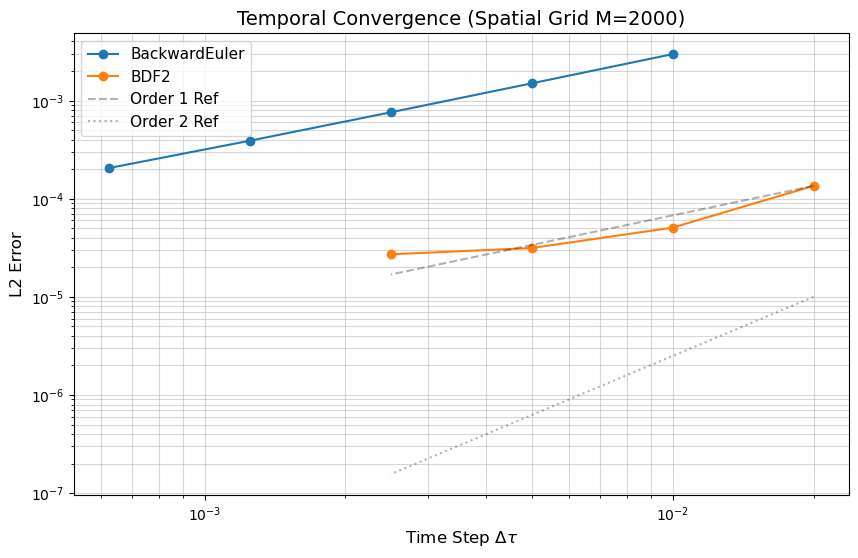

In [3]:

def run_convergence_test():
    # Use standard params for testing
    p = BSParams(S_max=400, K=100, T=1, r=0.05, sigma=0.2, q=0)
    
    # IMPORTANT: Use a fine spatial grid to isolate temporal error
    M = 2000 
    
    methods = ['BackwardEuler', 'BDF2']
    # Different step sizes for BDF2 to see convergence before saturation
    steps_config = {
        'BackwardEuler': [100, 200, 400, 800, 1600],
        'BDF2': [50, 100, 200, 400] 
    }
    
    plt.figure(figsize=(10, 6))
    
    print(f"{'Method':<15} {'N':<6} {'Error (L2)':<15} {'EOC':<10}")
    print("-" * 50)

    for method in methods:
        N_list = steps_config[method]
        errors = []
        dtaus = []
        old_error = None
        
        print(f"--- {method} ---")
        for N in N_list:
            S_grid, V_num, _ = solve_ode_system(method, N, M, p)
            V_true = exact_solution(S_grid, p.T, p)
            
            # L2 Error Norm
            error = np.linalg.norm(V_num - V_true) / np.sqrt(M)
            errors.append(error)
            dtaus.append(p.T / N)
            
            # Calculate EOC
            eoc_str = "-"
            if old_error is not None:
                # ratio = log(old/new) / log(N_new/N_old)
                # Since N doubles, log(2) is denominator
                eoc = np.log(old_error / error) / np.log(2)
                eoc_str = f"{eoc:.2f}"
            
            print(f"{method:<15} {N:<6} {error:.2e}{'':<5} {eoc_str:<10}")
            old_error = error
            
        # Plotting Log-Log
        plt.loglog(dtaus, errors, 'o-', label=f'{method}')

    # Add reference slopes
    ref_dt = np.array(dtaus)
    # Adjust intercepts slightly for visual clarity
    plt.loglog(ref_dt, errors[0]*(ref_dt/ref_dt[0])**1, 'k--', alpha=0.3, label='Order 1 Ref')
    plt.loglog(ref_dt, 1e-5*(ref_dt/ref_dt[0])**2, 'k:', alpha=0.3, label='Order 2 Ref')
    
    plt.xlabel(r'Time Step $\Delta \tau$', fontsize=12)
    plt.ylabel('L2 Error', fontsize=12)
    plt.title('Temporal Convergence (Spatial Grid M=2000)', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, which="both", ls="-", alpha=0.5)
    
    # SAVE FIGURE
    save_path = 'images/L-L_result.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n[Info] Plot saved to: {save_path}")
    
    plt.show()

run_convergence_test()

## 3. Calculation of Greeks (Delta and Gamma)

[Info] Plot saved to: images/greeks_plot.png


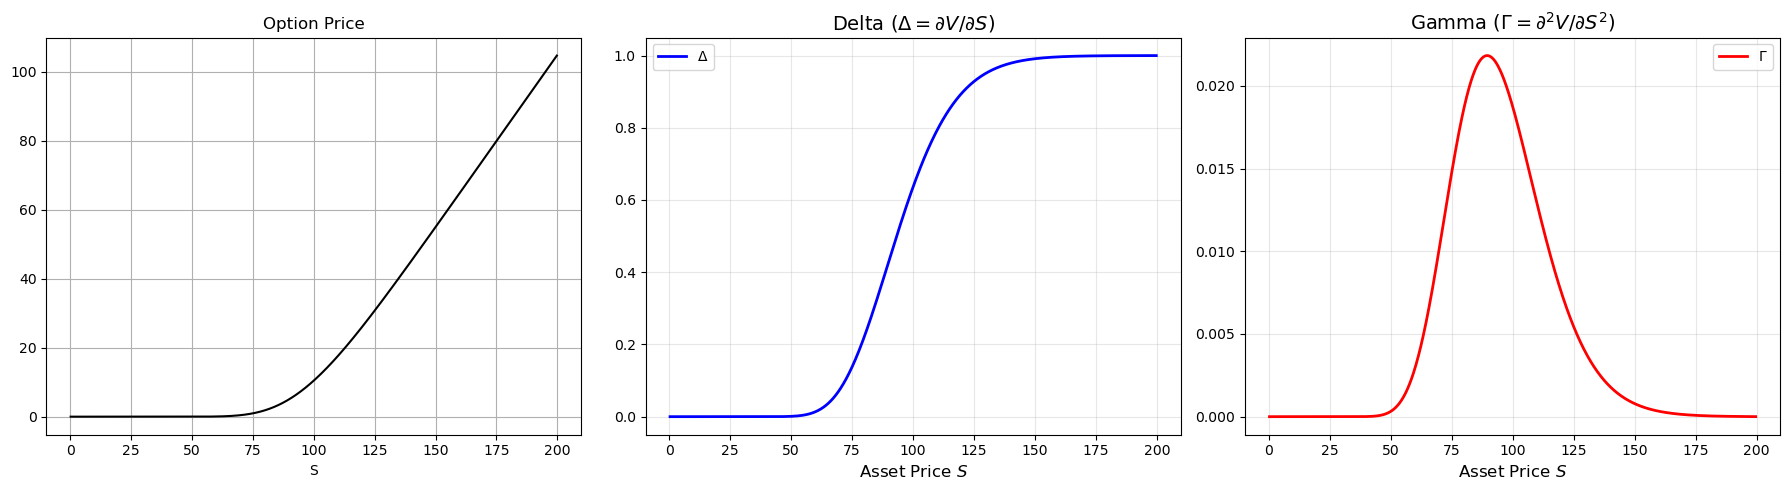

In [4]:
def plot_greeks():
    p = BSParams(S_max=200, K=100, T=1, r=0.05, sigma=0.2)
    M = 1000
    N = 500
    
    # Solve for V
    S_grid, V, dS = solve_ode_system('BDF2', N, M, p)
    
    # Numerical Differentiation
    # Delta = dV/dS (Central Difference)
    Delta = (V[2:] - V[:-2]) / (2 * dS)
    
    # Gamma = d2V/dS2 (Central Difference)
    Gamma = (V[2:] - 2*V[1:-1] + V[:-2]) / (dS**2)
    
    # Corresponding S grid for Greeks (trimmed edges)
    S_greeks = S_grid[1:-1]
    
    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    # Price
    ax[0].plot(S_grid, V, 'k-', label='Option Price V')
    ax[0].set_title('Option Price')
    ax[0].set_xlabel('S')
    ax[0].grid(True)
    
    # Delta
    ax[1].plot(S_greeks, Delta, 'b-', lw=2, label=r'$\Delta$')
    ax[1].set_title(r'Delta ($\Delta = \partial V / \partial S$)', fontsize=14)
    ax[1].set_xlabel('Asset Price $S$', fontsize=12)
    ax[1].grid(True, alpha=0.3)
    ax[1].legend()
    
    # Gamma
    ax[2].plot(S_greeks, Gamma, 'r-', lw=2, label=r'$\Gamma$')
    ax[2].set_title(r'Gamma ($\Gamma = \partial^2 V / \partial S^2$)', fontsize=14)
    ax[2].set_xlabel('Asset Price $S$', fontsize=12)
    ax[2].grid(True, alpha=0.3)
    ax[2].legend()
    
    plt.tight_layout()
    
    # SAVE FIGURE
    save_path = 'images/greeks_plot.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"[Info] Plot saved to: {save_path}")

    
    plt.show()

plot_greeks()